- データから次の着手を予測するDLの構築
- Kerasの紹介
- CNNの理解
- 盤面のベクトル表現
- 新たな活性化関数，ソフトマックス，整流線型ユニット(ReLU)

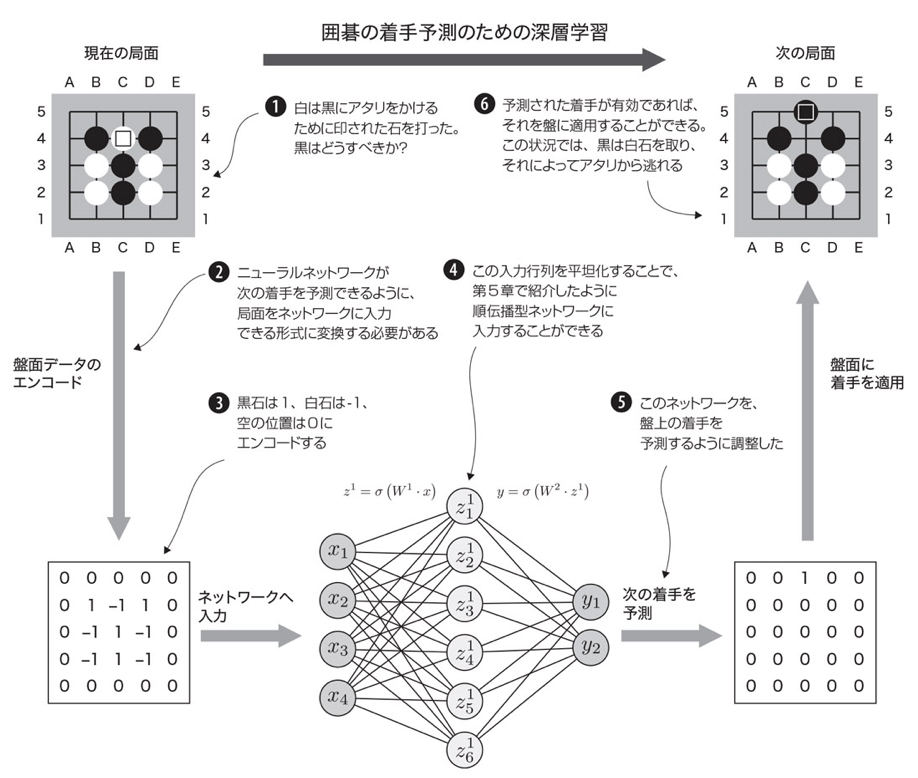

## NNのための局面エンコーディング
局面をNNで扱える表現にするためのエンコーダと元の局面に戻すデコーダを実装

dlgo/encodersに\_\_init\_\_.pyとbase.pyを作成  
base.pyにインタフェースとしてのEncoderクラスを作成  
- Encoder
    - name: ログ，保存
    - encode: 盤面->数値データ
    - encode_point: 盤上の点->整数インデックス
    - decode_point_index: 整数インデックス->盤上の点
    - num_points: 盤上の点の数(盤の幅\*高さ)
    - shape: エンコードされた盤面の構造の形状

base.pyに名前でエンコーダを作成できる関数get_encoder_by_nameを作成  

とりあえず黒は1,白は-1，無いところは0に盤面をエンコードするエンコーダを作る
dlgo/encoders/oneplane.pyを作成し，OnePlaneEncoderを作成  
oneplaneモジュールからOnePlaneEncoderを作成するcreate関数も作成  
内容は，先ほどのインタフェースを実装するようにする

## 木探索によるネットワークの訓練データの生成
ここではMCTSを使って自分自身でゲーム記録を生成してみる  
MCTSエージェントでゲームを進めつつエンコードするgenerate_game関数を定義  
実際にゲームデータを作成するmain関数も定義  
  
goboard_fastを動かすため
- utils.pyにMoveAgeクラスを追加
- [scoring.py](https://raw.githubusercontent.com/maxpumperla/deep_learning_and_the_game_of_go/master/code/dlgo/scoring.py)を作成
- goboard_fastのimportのコメントアウトされているところを外す
- generate_zobrist.pyのstateのループにNoneを追加して再生成  
    - python generate_zobrist.py > zobrist.py

In [1]:
import numpy as np
from IPython.display import clear_output
from dlgo.encoders.base import get_encoder_by_name
from dlgo import goboard_fast as goboard
from dlgo.mcts.mcts import MCTSAgent

In [2]:
def generate_game(board_size, rounds, max_moves, temperature):
    """ MCTSエージェントによる対局データを生成 """
    boards = []
    moves = []
    encoder = get_encoder_by_name('oneplane', board_size)
    game = goboard.GameState.new_game(board_size)
    bot = MCTSAgent(rounds, temperature)
    num_moves = 0

    # 普通にゲームを進めつつ，盤の状況と着手をエンコードしていく
    while not game.is_over():
        move = bot.select_move(game)
        if move.is_play:
            boards.append(encoder.encode(game))
            move_one_hot = np.zeros(encoder.num_points())
            move_one_hot[encoder.encode_point(move.point)] = 1
            moves.append(move_one_hot)
        
        game = game.apply_move(move)

        # ゲーム終了までの着手数制限を設ける
        num_moves += 1
        if num_moves > max_moves:
            break

    return np.array(boards), np.array(moves)

In [4]:
BOARD_SIZE = 9
ROUNDS = 10 # 1000
TEMPERATURE = 0.8
MAX_MOVES = 60
NUM_GAMES = 20
BOARD_OUT = "../datasets/dlgo/features-20.npy"
MOVE_OUT = "../datasets/dlgo/labels-20.npy"

Xs = []
ys = []

for i in range(NUM_GAMES):
    clear_output()
    print(f"Generating game {i+1} / {NUM_GAMES}")
    X, y = generate_game(BOARD_SIZE, ROUNDS, MAX_MOVES, TEMPERATURE)
    Xs.append(X)
    ys.append(y)

# numpyデータとして保存するためにリストを結合
X = np.concatenate(Xs)
y = np.concatenate(ys)

np.save(BOARD_OUT, X)
np.save(MOVE_OUT, y)
print("Saved")

Generating game 20 / 20


ちゃんと作ると大変時間がかかるので，データもらってくる  
https://github.com/maxpumperla/deep_learning_and_the_game_of_go/tree/master/code/generated_games  
features-40k.npy, labels-40k.npyは5000MCTSラウンドで数百のゲームに渡る40000の着手を元に生成されたデータである  
これらを../datasets/dlgoに保存

## 深層学習ライブラリKeras
前章で書いたような低レベルのNNに関する処理はライブラリに任せたい  
本書では，2015年に設立された深層学習ツールKerasを用いる  
Kerasの強み
- APIが直感的で使いやすく，プロトタイピングと実験サイクルが高速  
- 拡張性が高く，新しいカスタムレイヤーの追加などがしやすい
- 一般的なデータセットを直接読み込み可能
  
Kerasはバックエンドという概念を持つのが特徴  
Keras自身は深層学習のフロントエンドとなり，そのバックエンドとしてTensorFlow, Theano, MicrosoftCognitiveToolkitを選べる  
  
kerasによる深層学習のワークフローは4ステップからなる  
- データの前処理
- モデル定義
- モデルのコンパイル
- モデルの訓練と評価
  
あと，[kerasの小ネタ](https://keras.io/ja/getting-started/faq/)

インストール
``` bash
$ pip install tensorflow keras
```
GPUを使うのにtensorflow-gpuというものも必要だが，これはCUDAのバージョンによってインストールするバージョンを変える必要がある模様

あと学校のGPU使うときは[ここ](https://blog.amedama.jp/entry/2017/06/07/220723)に書いてあるように必要な分だけのメモリを確保するようにしよう

ここでは，前章でやったMNISTをkerasでやってみる  
もともと前章がkerasを意識した実装だったので，似たように実装できる  

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense

#### データの読み込みと前処理
なお，kerasのload_dataで読み込まれるデータはユーザホームの.keras/datasetsに保存される．変更したければload_dataの引数pathを設定  
しかし，どうせ他のところでも使うんだろうしホームに置いとくのがいいかと

In [11]:
# MNISTデータの読み込み
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# flatten
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# floatにして正規化
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# ラベルはto_categoricalによってone-hotベクトル化する
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

#### モデルを構築  
Sequentialをインスタンス化したあと層をaddで追加していく  
層は出力のサイズを基本的に指定．最初以外は前の層から自動判定  
activationも引数として名前で指定できる

In [6]:
model = Sequential()
model.add(Dense(392, activation='sigmoid', input_shape=(784,)))
model.add(Dense(196, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_5 (Dense)              (None, 196)               77028     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1970      
Total params: 386,718
Trainable params: 386,718
Non-trainable params: 0
_________________________________________________________________


#### モデルのコンパイル
損失関数とオプティマイザを指定し，学習可能な状態にする  
metricsはmodel.evaluateで得たい指標を設定する．  
epochごとにmetricsを表示してくれる  
accuracyはモデルの最高スコアの予測が実際のラベルと一致する頻度を示す

In [8]:
model.compile(
        loss='mean_squared_error',
        optimizer='sgd',
        metrics=['accuracy']
)

#### モデルの訓練と評価
訓練データ，バッチサイズ，エポック数を与えてfitを呼ぶことで訓練

In [12]:
model.fit(x_train, y_train, batch_size=128, epochs=20)
clear_output()
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 26us/step
Test loss: 0.08885958226919174
Test accuracy: 0.2599


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

2624 3 1


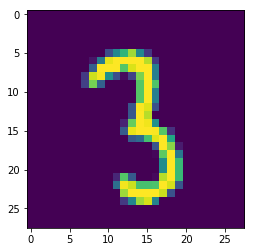

In [71]:
i = np.random.randint(len(x_test))
pred = model.predict(np.array([x_test[i]]))
plt.imshow(x_test[i].reshape((28, 28)))
print(i, np.argmax(y_test[i]), np.argmax(pred))

以上のように，kerasでは4ステップの迅速な実験サイクルが可能になっている．  
にしてもちゃんと学習できてなくない？

### kerasの順伝播型NNによる着手予測
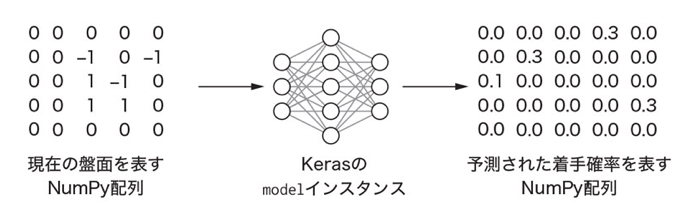

データの読み込みと前処理

In [15]:
np.random.seed(123)
X = np.load('../datasets/dlgo/features-40k.npy')
Y = np.load('../datasets/dlgo/labels-40k.npy')
sample_num = X.shape[0]
board_size = 9 * 9

# flatten
X = X.reshape(sample_num, board_size)
Y = Y.reshape(sample_num, board_size)

# 訓練データとテストデータに分ける
train_sample_num = int(0.9 * sample_num)
X_train, X_test = X[:train_sample_num], X[train_sample_num:]
Y_train, Y_test = Y[:train_sample_num], Y[train_sample_num:]

モデルの構築，コンパイル，訓練

In [79]:
model = Sequential()
model.add(Dense(200, activation='sigmoid', input_shape=(board_size,)))
model.add(Dense(300, activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))
model.add(Dense(board_size, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 200)               16400     
_________________________________________________________________
dense_12 (Dense)             (None, 300)               60300     
_________________________________________________________________
dense_13 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_14 (Dense)             (None, 81)                16281     
Total params: 153,181
Trainable params: 153,181
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.compile(
        loss='mean_squared_error',
        optimizer='sgd',
        metrics=['accuracy']
)

In [81]:
model.fit(X_train, Y_train, 
          batch_size=64,
          epochs=5,
          verbose=1,
          validation_data=(X_test, Y_test)
)

clear_output()
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test acc:', score[1])

Test loss: 0.02392642795464247
Test acc: 0.017615830115830115


9\*9＝81手の選択肢があるので，次の手がランダムで当たる確率は約0.12  
訓練後のaccは0.15~0.25程度になるが，これはランダムよりは良い

サンプルの局面を与えることで洞察を得られる  
黒はAに，白はBに置けば2目取れるという状況

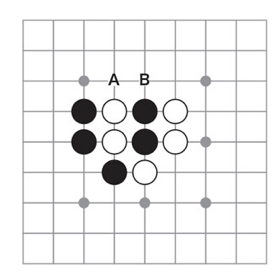

In [94]:
sample = np.array([[
    0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,
    0,1,-1,1,-1,0,0,0,0,
    0,1,-1,1,-1,0,0,0,0,
    0,0,1,-1,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,
]])

move_probs = model.predict(sample)[0].reshape(9,9)
np.set_printoptions(precision=3)
print(move_probs)
np.set_printoptions(precision=8)

# argmaxはflattenを処理に含んでいる
# unravel_indexは数字とshapeを与えるとshapeにした時のインデックスを返す
print(np.unravel_index(move_probs.argmax(), move_probs.shape))

[[0.114 0.129 0.125 0.129 0.105 0.114 0.128 0.113 0.104]
 [0.106 0.115 0.13  0.122 0.112 0.122 0.116 0.119 0.111]
 [0.115 0.122 0.139 0.129 0.123 0.114 0.102 0.123 0.118]
 [0.114 0.143 0.121 0.112 0.142 0.116 0.117 0.113 0.117]
 [0.136 0.133 0.12  0.124 0.111 0.141 0.126 0.124 0.107]
 [0.12  0.126 0.122 0.116 0.128 0.116 0.119 0.137 0.101]
 [0.11  0.13  0.121 0.122 0.102 0.118 0.106 0.125 0.131]
 [0.121 0.117 0.114 0.113 0.128 0.125 0.119 0.107 0.114]
 [0.123 0.129 0.127 0.12  0.12  0.141 0.113 0.124 0.13 ]]
(3, 1)


好ましい結果にはならない．  
すでに石があるところやあまり関係ないところにもスコアが及んでいる  
しかし，それらの部分は比較的小さいスコアになっている  
囲碁の概念を理解はしてきている模様

以降は次のポイントに対処 
- 多層パーセプトロンは向かないのでCNNを用いる
- 分類タスクに調整されたクロスエントロピー誤差を使用する
- シグモイド以外の活性化関数を試す
- MCTS自体がおかしな着手をすることがあるので，人間の対局データから学習

## 畳み込みネットワークによる空間解析
囲碁には虎口，タケフ，花六といった石の配置の定型パターンがある  
このような空間的配置を意識するのに，畳み込みNN(CNN)がある  
CNNは画像，音声，テキストといったものにも適用できる  

### 直観的に，畳み込みとは何か
画像処理の畳み込みが由来  

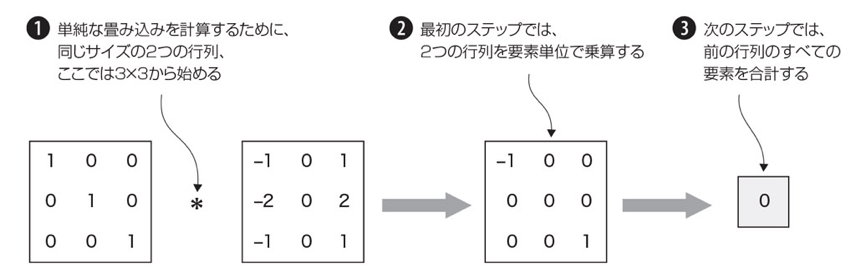

2つある行列の片方を入力画像，他方を入力より小さい畳み込みカーネルとする  
畳み込みカーネルはカーネル，フィルタとも呼ばれる

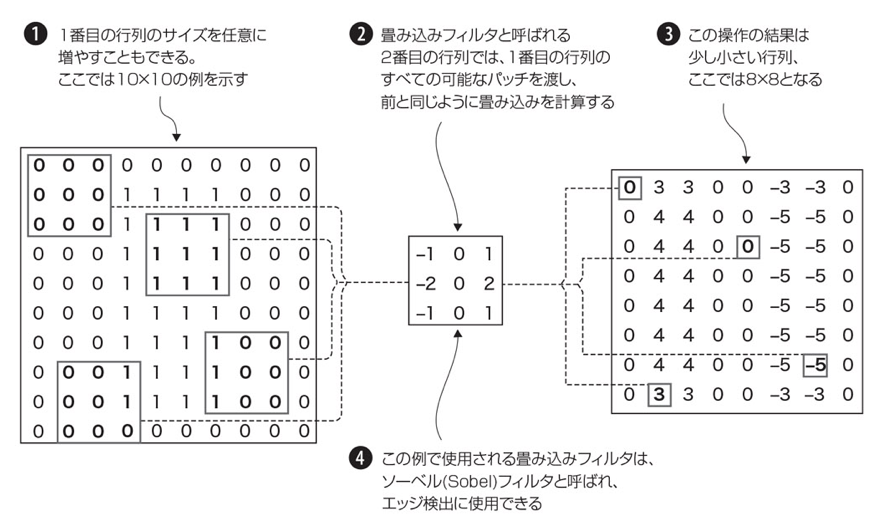

このカーネルは次のことを意味するので，入力画像の垂直エッジを検出する  
- 全てのピクセル値が同じ入力画像に適用すると出力は0
- 左の列の値が右の列より大きいと負の値になる
- 右の列の値が左の列より大きいと正の値になる

このカーネルを90度回転させれば水平エッジ検出ができる  
  
他にも，カーネルを変えてやることで画像をぼかしたり，鮮明にしたりできる  
基本的なフィルタ処理はOpenCVなどの画像処理ライブラリにある

畳み込みを使用することで，画像から価値のある情報を検出できる  
このカーネルを学習させるのがCNNのアイデア  
以降，カーネルによる畳み込みの出力画像を特徴マップと呼ぶ  

学習対象のフィルタによって特徴マップを生成する層を畳み込み層と呼ぶ  
畳み込み層では複数の画像(チャンネル)に対してそれぞれ複数のフィルタをかける  
例えば，3チャンネル4フィルタなら，12個の特徴マップを出力する

全結合層，畳み込み層，(プーリング層)からなるNNを畳み込みNNと呼ぶ  
畳み込み層は，全結合層よりもパラメータが少なくなり，演算時間がかかる

### プーリング層による空間の削減
画像を縮小することでニューロンの数を減らすことを目的とするプーリング層  
例えば(2,2)の窓の中の最大値や平均値をとって出力  
これで1/4の画像になり，パラメータ数を減らせる  
このようにダウンサンプリングすることで少し情報を失うが予測精度は十分保てる

### kerasによるCNNの構築
盤面データのような2次元データの畳み込みを実行するConv2D層を使用  
さらに2次元データを全結合層に入力するため平坦化するFlattenという層も使用

In [5]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

データの読み込みと前処理

In [96]:
np.random.seed(123)
X = np.load('../datasets/dlgo/features-40k.npy')
Y = np.load('../datasets/dlgo/labels-40k.npy')
sample_num = X.shape[0]
size = 9

# 本来はチャンネルに当てられる部分の層も便宜上追加する
input_shape = (size, size, 1)
X = X.reshape(sample_num, size, size, 1)

# 訓練データとテストデータに分ける
train_sample_num = int(0.9 * sample_num)
X_train, X_test = X[:train_sample_num], X[train_sample_num:]
Y_train, Y_test = Y[:train_sample_num], Y[train_sample_num:]

モデルの構築

In [102]:
model = Sequential()
model.add(Conv2D(
    filters=48,               # フィルタ数
    kernel_size=(3,3), # カーネルサイズ
    padding='same',     # 畳み込みの出力の周りに0埋めをして入力と同サイズにする
    activation='sigmoid',
    input_shape=input_shape
))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(48, (3,3), padding='same', activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) # 以降の全結合層のためflatten
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(size * size, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 9, 9, 48)          480       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 48)          20784     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 48)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               24704     
_________________________________________________________________
dense_24 (Dense)             (None, 81)                10449     
Total para

In [103]:
model.compile(
        loss='mean_squared_error',
        optimizer='sgd',
        metrics=['accuracy']
)

In [104]:
model.fit(X_train, Y_train, 
          batch_size=64,
          epochs=5,
          verbose=1,
          validation_data=(X_test, Y_test)
)

clear_output()
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test acc:', score[1])

Test loss: 0.0314107776033372
Test acc: 0.018822393822393823


畳み込み層を取り入れたからと言って結果が大変よくなるわけでは今の所ない  

## 囲碁の着手確率の予測
次の着手の盤上での確率分布を，ソフトマックス活性化関数で求める

### 最後の層にソフトマックス活性化関数を使用
ソフトマックス活性化関数はロジスティックシグモイド関数$\sigma$の一般化  
$$ \rm{softmax}(x_i)=\frac{e^{x_i}}{\sum_{j=1}^l e^{x_j}} $$
$e$を使うことで微分が簡単になり，かつどんな$x$にも非負になる性質がある  
さらに，その$i$に渡る合計は1になるため，ソフトマックス関数は確率を出力する

In [6]:
def softmax(x):
    e_x = np.exp(x)
    e_x_sum = np.sum(e_x)
    return e_x / e_x_sum

x = np.array([100, 100])
print(softmax(x))

[0.5 0.5]


kerasでは，layerの初期化時にactivatition='softmax'を設定することで使用可能

### 分類問題のための交差エントロピー誤差
最小二乗誤差(MSE)は出力が連続な範囲である回帰問題に有効  
分類問題ではMSEのペナルティが大きすぎる  
